In [9]:
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import cv2
from sklearn.metrics import jaccard_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from skimage import data, segmentation, feature, future, measure
import xgboost as xgb
import pandas as pd
import random
from functools import partial
import os
import shutil

random.seed(42)
np.random.seed(42)

In [10]:
def resize_padding(image, RGB, h_target, w_target):
    """Adds some padding to an image to correspond to specified height and width

    Args:
        image (ndarray): image name
        RGB (boolean): True if RGB (3 channels), False if greyscale
        h_target (int): wanted number of pixels for height
        w_target (int): wanted number of pixels for width
    
    Returns:
        result (ndarray): padded image
    """

    h, w = image.shape[0:2]
    if h_target < h or w_target < w:
        print("Specified dimensions smaller than the input image")
        return None
        
    delta_h = h_target - h
    delta_w = w_target - w

    pad_up = delta_h//2
    pad_down = h_target - h - pad_up
    pad_left = delta_w//2
    pad_right = w_target - w - pad_left

    if RGB:
        return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                                  cv2.BORDER_CONSTANT, value = [255,255,255])
    return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                              cv2.BORDER_CONSTANT, value = 0)

In [11]:
def crop(img, h, w):
    """Crops the image until to match with specified height and width values

    Args:
        img (ndarray): image name
        h (int): wanted number of pixels for height
        w (int): wanted number of pixels for width

    Returns:
        img (ndarray): cropped image
    """
    diff_h = img.shape[0] - h
    diff_w = img.shape[1] - w
    if diff_h > 0:
        if diff_h%2 == 0:        
            img = img[diff_h//2:img.shape[0] - diff_h//2, :]
        else:
            img = img[diff_h//2 + 1:img.shape[0] - diff_h//2, :]
    if diff_w > 0:
        if diff_w%2 == 0:
            img = img[:, diff_w//2:img.shape[1] - diff_w//2]
        else:
            img = img[:, diff_w//2 + 1:img.shape[1] - diff_w//2]
    return img

In [12]:
SIZE_H = 720
SIZE_W = 464

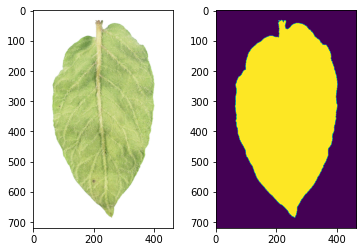

In [13]:
files_vis = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Train_dataset/Vis/*").files
files_gt = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Train_dataset/GT/*").files
vis = [ski.io.imread(image_path) for image_path in files_vis]
gt = [ski.io.imread(image_path) for image_path in files_gt]

vis_padded = [resize_padding(im, True, SIZE_H, SIZE_W) for im in vis]
gt_padded = [resize_padding(im, False, SIZE_H, SIZE_W) for im in gt]

for im in gt_padded:       
    im[im == 0] = 0
    im[im == 100] = 1
    im[im == 200] = 2

plt.subplot(121)
plt.imshow(vis_padded[25])
plt.subplot(122)
plt.imshow(gt_padded[25])
plt.show()

In [14]:
SIGMA_MIN = 1
SIGMA_MAX = 32

features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, 
                        channel_axis = -1)

In [16]:
X = []
Y = []

for i, img in enumerate(vis_padded):
    features = features_func(img)
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2]) 

    keep_pixel = .2             
    keep = random.sample(range(features.shape[0]), round(features.shape[0]*keep_pixel))
    features = np.array([features[j,:] for j in keep])

    label = gt_padded[i].ravel()
    label = np.array([label[j] for j in keep])
    X.append(features)
    Y.append(label)

X = np.array(X)
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
Y = np.array(Y)
Y = Y.reshape(Y.shape[0]*Y.shape[1],)

In [ ]:
model = xgb.XGBClassifier()

params = {"n_estimators" : [100, 150, 200],
 "learning_rate" : [.05, .1, .2],
 "max_depth" : [4, 6, 8, 10],
 "min_child_weight" : [1, 3, 5, 7],
 "gamma": [.0, .2, .4],
 "colsample_bytree" : [.75, 1]
}

model_random = RandomizedSearchCV(model, param_distributions = params, cv = 3, n_iter = 50)
model_random.fit(X, Y)
model_random.best_params_

Output from previous cell:

{'n_estimators': 150, <br>
 'min_child_weight': 5, <br>
 'max_depth': 10, <br>
 'learning_rate': 0.2, <br>
 'gamma': 0.0, <br>
 'colsample_bytree': 0.75}

In [17]:
model = xgb.XGBClassifier(n_estimators = 150,             
                            min_child_weight = 5, 
                            max_depth = 10, 
                            learning_rate = .2,
                            gamma = 0,
                            colsample_bytree = 0.75) 
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [18]:
files_test_vis = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Test_dataset/Vis/*").files
files_test_gt = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Test_dataset/GT/*").files
test_vis = [ski.io.imread(image_path) for image_path in files_test_vis]
test_gt = [ski.io.imread(image_path) for image_path in files_test_gt]
for im in test_gt:             
    im[im == 0] = 0
    im[im == 100] = 1
    im[im == 200] = 2
    
num = 0
true_label = test_gt[num]
img = test_vis[num]
or_shape = img.shape

test_features = features_func(img)
test_features = test_features.reshape(test_features.shape[0]*test_features.shape[1], test_features.shape[2])

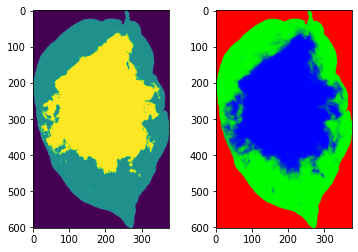

Jaccard score :  0.7695041152601
Balanced accuracy :  0.8672951434095357


In [19]:
prediction_test = model.predict(test_features)
prediction_test_proba = model.predict_proba(test_features)
prediction_test_img = prediction_test.reshape(or_shape[0], or_shape[1])
prediction_test_proba= prediction_test_proba.reshape(or_shape[0], or_shape[1], 3)

plt.subplot(121)
plt.imshow(prediction_test_img)
plt.subplot(122)
plt.imshow(prediction_test_proba)
plt.show()

print("Jaccard score : ", 
    jaccard_score(pd.DataFrame(prediction_test_img.flatten()), pd.DataFrame(true_label.flatten()), average = 'macro'))
print("Balanced accuracy : ", 
    balanced_accuracy_score(pd.DataFrame(prediction_test_img.flatten()), pd.DataFrame(true_label.flatten())))

**Predictions on the whole test dataset:**

In [20]:
predictions = []
proba_map = []
proba_map_ch1 = []   #proba of background
proba_map_ch2 = []   #proba of healthy
proba_map_ch3 = []   #proba of infected
iou_score = []
b_accuracy_score = []

t = len(test_vis)

for i in range(t):
    img = test_vis[i]
    true_label = test_gt[i]
    or_shape = img.shape
    features = features_func(img)
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2])

    pred = model.predict(features)
    pred_proba = model.predict_proba(features)
    pred_img = pred.reshape(or_shape[0], or_shape[1])
    pred_proba= pred_proba.reshape(or_shape[0], or_shape[1], 3)

    jac = jaccard_score(pd.DataFrame(pred_img.flatten()), pd.DataFrame(true_label.flatten()), average = 'macro')
    b_acc = balanced_accuracy_score(pd.DataFrame(pred_img.flatten()), pd.DataFrame(true_label.flatten()))

    predictions.append(pred_img)
    proba_map.append(pred_proba)
    proba_map_ch1.append(pred_proba[:,:,0])
    proba_map_ch2.append(pred_proba[:,:,1])
    proba_map_ch3.append(pred_proba[:,:,2])
    iou_score.append(jac)
    b_accuracy_score.append(b_acc)

mean_IOU = np.mean(iou_score)
mean_b_acc = np.mean(b_accuracy_score)
print("################################################################")
print("Mean IoU obtained on test dataset : ", round(mean_IOU, 5))
print("Mean balanced accuracy obtained on test dataset : ", round(mean_b_acc, 5))
print("################################################################")

################################################################
Mean IoU obtained on test dataset :  0.85059
Mean balanced accuracy obtained on test dataset :  0.90487
################################################################


IoU : 0.7695
Balanced accuracy : 0.8673


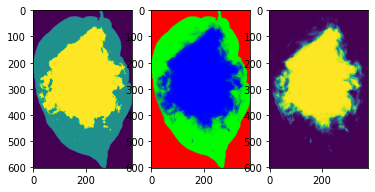

IoU : 0.80651
Balanced accuracy : 0.94155


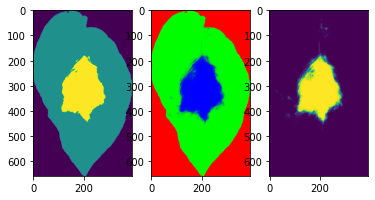

IoU : 0.99828
Balanced accuracy : 0.99923


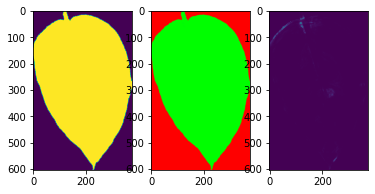

IoU : 0.69761
Balanced accuracy : 0.71559


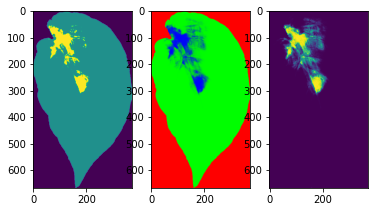

IoU : 0.9302
Balanced accuracy : 0.98757


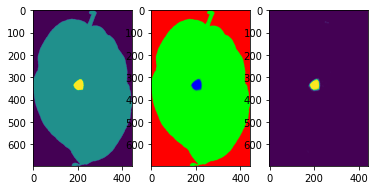

IoU : 0.90146
Balanced accuracy : 0.91798


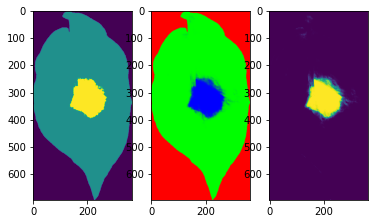

In [21]:
for i in range(t):
    print("IoU :", round(iou_score[i], 5))
    print("Balanced accuracy :", round(b_accuracy_score[i], 5))
    plt.subplot(131)
    plt.imshow(predictions[i])
    plt.subplot(132)
    plt.imshow(proba_map[i])
    plt.subplot(133)
    plt.imshow(proba_map_ch3[i])
    plt.show()

### Segmentation and post-processing on the whole dataset

In [88]:
def segmentXGB(img):
    """Segmentation of leaf image using XGBoost + probability map of infected

    Args:
        img (ndarray): image name
    Returns:
        pred_probas_reshape[:,:,2] (ndarray): probability map of infected
        pred_reshape*100 (ndarray): segmented image
    """
    or_shape = img.shape
    features = features_func(img)
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2])

    pred = model.predict(features)  
    pred_probas = model.predict_proba(features)
    
    pred_reshape = np.array(pred.reshape(or_shape[0],or_shape[1]), dtype = np.uint8)
    pred_probas_reshape = pred_probas.reshape(or_shape[0],or_shape[1], 3)

    return pred_probas_reshape[:,:,2], pred_reshape*100

We will now apply the function to all visible images. We will also perform an additionnal postprocessing step, to ensure that 1 pixel at day t cannot have higher value than the one at day t+1.  

In [ ]:
folders = ski.io.imread_collection('/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Dossiers_Mildiou_Maj2023' + '/*') 
iteration = 0
for folder in folders.files:
    iteration +=1
    if os.path.exists(folder + '/Segment_XGB'):   
        shutil.rmtree(folder + '/Segment_XGB')
    Images = ski.io.imread_collection(folder +  '/Recalibrated_CPD/*').files
    Visible = []
    for im in Images:
        if not any([x in im for x in ['Fv', 'Fo', 'Fm', 'FvFm', 'error']]):     
            Visible.append(im)
    Visible = sorted(Visible, key=str.casefold, reverse=True) #sort in reverse order for upcoming postprocessing

    os.mkdir(folder + '/Segment_XGB')   
    d = 0
    for im_path in Visible:
        im = ski.io.imread(im_path)
        res = segmentXGB(im)

        if len(Visible) == 4 and "_J5_" not in im_path or len(Visible) == 3 and "_J4_" not in im_path:  
            p_map = res[0]
            seg = res[1]
            for i in range(p_map.shape[0]):
                for j in range(p_map.shape[1]):
                    if p_map[i, j] > p_map_upcoming_day[i, j]:
                        p_map[i, j] = p_map_upcoming_day[i, j]
            p_map_upcoming_day = p_map
        else:
            p_map = res[0]
            p_map_upcoming_day = p_map
            seg = res[1]

        ski.io.imsave(folder + '/Segment_XGB' + '/P_map_'+ im_path.rsplit('/', 1)[-1], p_map)
        ski.io.imsave(folder + '/Segment_XGB' + '/Seg_' + im_path.rsplit('/', 1)[-1], seg)